In [1]:
%matplotlib inline
import numpy as np
import cv2
from incisorseg.dataset import Dataset,LeaveOneOutSplitter,load_image,load_landmark
from incisorseg.utils import *
from asm.shape import Shape, ShapeList
from asm.shapemodel import ShapeModel
from asm.greymodel import GreyModel
from asm.model import ActiveShapeModel

In [2]:
data = Dataset('../data/')

[[  76.9375   32.25  ]
 [ 110.625    83.875 ]]
(320, 2)


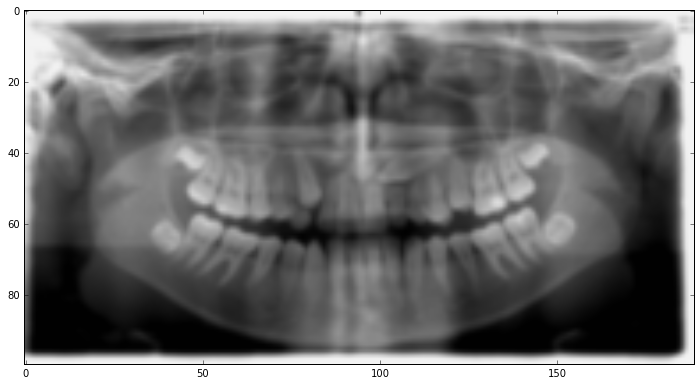

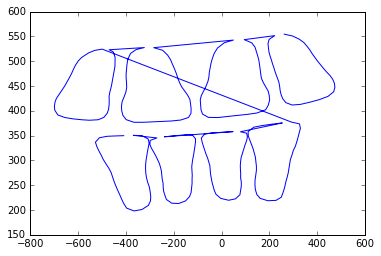

In [4]:
i = 0
for split in LeaveOneOutSplitter(data):
    if i > 0:
        break
    training_images,training_landmarks,training_segmentations = split.get_training_set()
    test_image,test_landmark,test_segmentation = split.get_test_example()
    scaled_training_images = training_images
    scaled_training_landmarks = training_landmarks
    scaled_test_image = test_image
    for j in range(4):
        scaled_test_image = cv2.pyrDown(scaled_test_image)
        scaled_training_images = [cv2.pyrDown(image) for image in scaled_training_images]
        scaled_training_landmarks = ShapeList([shape.pyr_down() for shape in scaled_training_landmarks])
        if j==3:
            print scaled_training_landmarks.bounding_box()
            model = ActiveShapeModel(scaled_training_images,scaled_training_landmarks)
            new_shape_combined,fit_error,_ = model.fit(scaled_test_image,1e-1,10)
            imshow2(overlay_shapes_on_image(scaled_test_image,[new_shape_combined.round()]))
            plot_shapes([new_shape_combined])

    #print split.get_dice_error_on_test(test_landmark)
    #print split.get_dice_error_on_test(model.initial_shape())
    #print split.get_dice_error_on_test(new_shape_combined)
    i +=1